In [1]:
import kagglehub
import shutil

# Download dataset to default location
path = kagglehub.dataset_download("mohammadamireshraghi/blood-cell-cancer-all-4class")

# Define target path
target_path = "/content/"

# Move the downloaded files to /content/ directory
shutil.move(path, target_path)

print("Path to dataset files:", target_path)


100%|██████████| 1.68G/1.68G [00:17<00:00, 100MB/s] 

Extracting files...


Path to dataset files: /content/


In [2]:
import shutil
import os

# Source and destination paths
source_path = '/content/1/'
destination_path = '/content/'

# Move files from /content/1/ to /content/
for filename in os.listdir(source_path):
    shutil.move(os.path.join(source_path, filename), destination_path)

# Optionally, you can remove the empty folder after moving the files
os.rmdir(source_path)

print("Files moved back to /content/")


Files moved back to /content/


In [3]:
# ============================
# 1. Import Libraries and Set Device
# ============================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [4]:
# ============================
# 2. Data Preparation
# ============================

# 2.1. Generate CSV File

def create_csv(data_dir, csv_filename):
    data = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                filepath = os.path.join(root, file)
                # Extract class information from the folder structure
                parts = filepath.split(os.sep)
                class_name = parts[-2]  # Adjust if your directory depth is different

                if class_name == 'Benign':
                    binary_label = 0
                    subtype_label = -1
                elif class_name == '[Malignant] Pre-B':
                    binary_label = 1
                    subtype_label = 0
                elif class_name == '[Malignant] Pro-B':
                    binary_label = 1
                    subtype_label = 1
                elif class_name == '[Malignant] early Pre-B':
                    binary_label = 1
                    subtype_label = 2
                else:
                    continue  # Skip unknown classes

                data.append([filepath, binary_label, subtype_label])

    df = pd.DataFrame(data, columns=['filepath', 'binary_label', 'subtype_label'])
    df.to_csv(csv_filename, index=False)
    print(f"CSV file saved to {csv_filename}")

# Usage
data_dir = r'/content/Blood cell Cancer [ALL]'  # Update this path to your dataset directory
create_csv(data_dir, 'dataset_labels.csv')


CSV file saved to dataset_labels.csv


In [5]:
# 2.2. Split Data into Train, Validation, and Test Sets

def split_data(csv_file, train_csv, val_csv, test_csv, val_size=0.1, test_size=0.1, random_state=42):
    df = pd.read_csv(csv_file)
    # For stratification, combine binary and subtype labels to ensure both are represented
    stratify_col = df['binary_label'].astype(str) + '_' + df['subtype_label'].astype(str)
    # Split data into train and temp (val + test)
    train_df, temp_df = train_test_split(
        df, test_size=val_size+test_size, random_state=random_state, stratify=stratify_col)
    # Recalculate stratify_col for temp_df
    stratify_col_temp = temp_df['binary_label'].astype(str) + '_' + temp_df['subtype_label'].astype(str)
    # Split temp_df into val and test
    val_df, test_df = train_test_split(
        temp_df, test_size=test_size/(val_size+test_size), random_state=random_state, stratify=stratify_col_temp)

    train_df.to_csv(train_csv, index=False)
    val_df.to_csv(val_csv, index=False)
    test_df.to_csv(test_csv, index=False)
    print(f"Training data saved to {train_csv}")
    print(f"Validation data saved to {val_csv}")
    print(f"Test data saved to {test_csv}")

# Usage
split_data('dataset_labels.csv', 'train_labels.csv', 'val_labels.csv', 'test_labels.csv')


Training data saved to train_labels.csv
Validation data saved to val_labels.csv
Test data saved to test_labels.csv


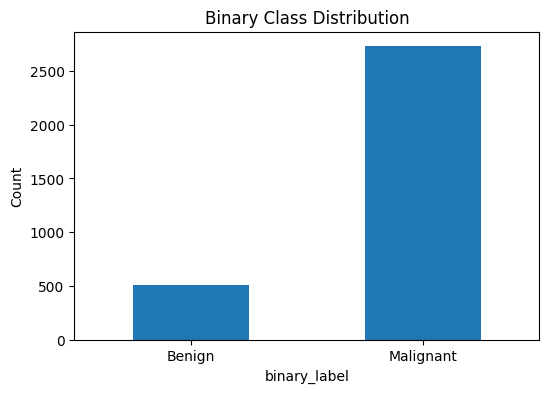

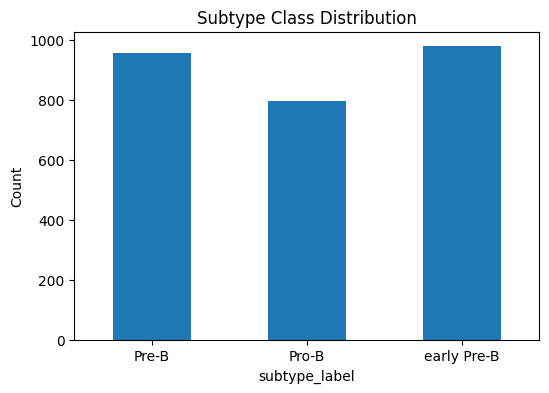

In [6]:
# ============================
# 3. Exploratory Data Analysis (EDA)
# ============================

# 3.1. Visualize Class Distribution

def plot_class_distribution(csv_file):
    df = pd.read_csv(csv_file)
    binary_counts = df['binary_label'].value_counts().sort_index()
    subtype_counts = df[df['subtype_label'] != -1]['subtype_label'].value_counts().sort_index()

    # Plot binary class distribution
    plt.figure(figsize=(6,4))
    binary_counts.plot(kind='bar')
    plt.title('Binary Class Distribution')
    plt.xticks([0,1], ['Benign', 'Malignant'], rotation=0)
    plt.ylabel('Count')
    plt.show()

    # Plot subtype class distribution
    plt.figure(figsize=(6,4))
    subtype_counts.plot(kind='bar')
    plt.title('Subtype Class Distribution')
    plt.xticks([0,1,2], ['Pre-B', 'Pro-B', 'early Pre-B'], rotation=0)
    plt.ylabel('Count')
    plt.show()

# Usage
plot_class_distribution('dataset_labels.csv')


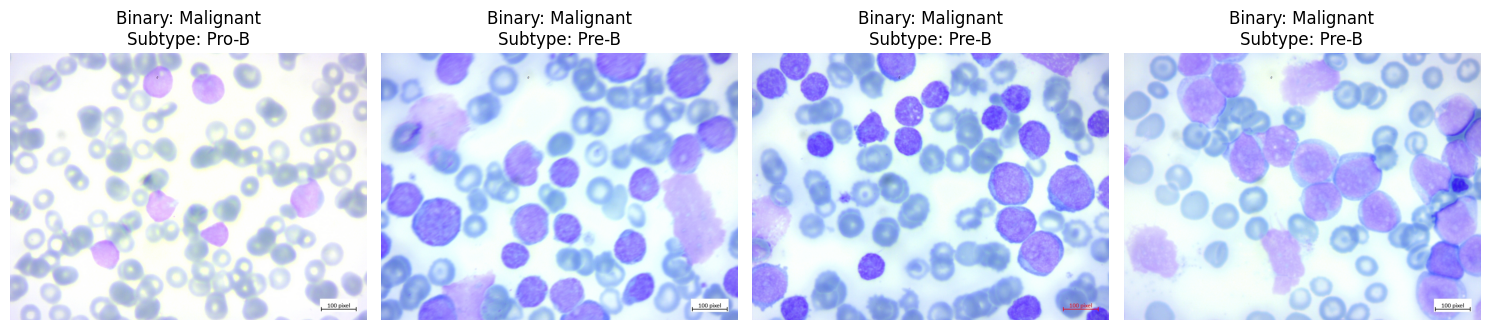

In [7]:
# 3.2. Display Sample Images

# Define label mappings
binary_label_map = {0: 'Benign', 1: 'Malignant'}
subtype_label_map = {
    -1: 'Not applicable',
    0: 'Pre-B',
    1: 'Pro-B',
    2: 'early Pre-B'
}

def show_sample_images(csv_file, num_samples=4):
    df = pd.read_csv(csv_file)
    sample_df = df.sample(n=num_samples)
    images = []
    titles = []

    for idx, row in sample_df.iterrows():
        img_path = row['filepath']
        image = Image.open(img_path).convert('RGB')
        images.append(image)
        binary_class_name = binary_label_map[row['binary_label']]
        subtype_class_name = subtype_label_map[row['subtype_label']]
        titles.append(f'Binary: {binary_class_name}\nSubtype: {subtype_class_name}')

    # Display images
    fig, axes = plt.subplots(1, num_samples, figsize=(15,5))
    for i in range(num_samples):
        axes[i].imshow(images[i])
        axes[i].set_title(titles[i], fontsize=12)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Usage
show_sample_images('dataset_labels.csv', num_samples=4)


In [8]:
# ============================
# 4. Define Dataset and DataLoaders
# ============================

# Custom Dataset Class
class BloodCellDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        image = Image.open(img_path).convert('RGB')
        binary_label = self.dataframe.iloc[idx]['binary_label']
        subtype_label = self.dataframe.iloc[idx]['subtype_label']

        if self.transform:
            image = self.transform(image)

        sample = {
            'image': image,
            'binary_label': torch.tensor(binary_label, dtype=torch.long),
            'subtype_label': torch.tensor(subtype_label, dtype=torch.long)
        }
        return sample

# Data Transforms with Enhanced Data Augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=20, shear=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = BloodCellDataset('train_labels.csv', transform=train_transforms)
val_dataset = BloodCellDataset('val_labels.csv', transform=val_transforms)
test_dataset = BloodCellDataset('test_labels.csv', transform=val_transforms)

# Create DataLoaders
batch_size = 16

# Update DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)


In [10]:
# ============================
# 5. Define Model (Resnet)
# ============================

# Multitask Model without BatchNorm1d
class MultiTaskModel(nn.Module):
    def __init__(self):
        super(MultiTaskModel, self).__init__()
        self.base_model = models.resnet50(pretrained=True)
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()  # Remove the original fc layer

        # Freeze early layers (Optional)
        for name, param in self.base_model.named_parameters():
            if 'layer4' not in name:
                param.requires_grad = False

        # Task-specific heads without BatchNorm
        self.binary_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
        self.subtype_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )

    def forward(self, x):
        x = self.base_model(x)
        binary_out = self.binary_classifier(x)
        subtype_out = self.subtype_classifier(x)
        return binary_out, subtype_out

# Instantiate the model
model = MultiTaskModel().to(device)


In [ ]:
# # ============================
# # 5. Define Model with VGG Backbone
# # ============================

# # Multitask Model with VGG Backbone
# class MultiTaskModelVGG(nn.Module):
#     def __init__(self):
#         super(MultiTaskModelVGG, self).__init__()
#         self.base_model = models.vgg16_bn(pretrained=True)
#         num_ftrs = self.base_model.classifier[6].in_features
#         # Remove the original classifier
#         self.base_model.classifier = nn.Identity()

#         # Freeze early layers (Optional)
#         for name, param in self.base_model.features.named_parameters():
#             param.requires_grad = False

#         # Task-specific heads
#         self.binary_classifier = nn.Sequential(
#             nn.Linear(num_ftrs, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 2)
#         )
#         self.subtype_classifier = nn.Sequential(
#             nn.Linear(num_ftrs, 256),
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(256, 3)
#         )

#     def forward(self, x):
#         x = self.base_model(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         binary_out = self.binary_classifier(x)
#         subtype_out = self.subtype_classifier(x)
#         return binary_out, subtype_out

# # Instantiate the model
# model = MultiTaskModelVGG().to(device)


In [11]:
# ============================
# 6. Training
# ============================

# 6.1. Training Function with Early Stopping

def train_model(model, train_loader, val_loader, criterion_binary, criterion_subtype, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc_binary': [],
        'val_acc_binary': [],
        'train_acc_subtype': [],
        'val_acc_subtype': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects_binary = 0
            running_corrects_subtype = 0
            total_subtype_samples = 0

            # Iterate over data
            for samples in dataloader:
                inputs = samples['image'].to(device)
                binary_labels = samples['binary_label'].to(device)
                subtype_labels = samples['subtype_label'].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    binary_outputs, subtype_outputs = model(inputs)
                    loss_binary = criterion_binary(binary_outputs, binary_labels)

                    # Filter out benign samples for subtype classification
                    subtype_mask = subtype_labels != -1
                    if subtype_mask.sum() > 0:
                        loss_subtype = criterion_subtype(
                            subtype_outputs[subtype_mask],
                            subtype_labels[subtype_mask]
                        )
                        loss = loss_binary + loss_subtype
                    else:
                        loss = loss_binary

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                _, preds_binary = torch.max(binary_outputs, 1)
                running_corrects_binary += torch.sum(preds_binary == binary_labels).item()

                if subtype_mask.sum() > 0:
                    _, preds_subtype = torch.max(subtype_outputs[subtype_mask], 1)
                    running_corrects_subtype += torch.sum(preds_subtype == subtype_labels[subtype_mask]).item()
                    total_subtype_samples += subtype_mask.sum().item()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc_binary = running_corrects_binary / len(dataloader.dataset)
            epoch_acc_subtype = running_corrects_subtype / total_subtype_samples if total_subtype_samples > 0 else 0

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Binary Acc: {epoch_acc_binary:.4f} Subtype Acc: {epoch_acc_subtype:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc_binary'].append(epoch_acc_binary)
                history['train_acc_subtype'].append(epoch_acc_subtype)
                scheduler.step()
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc_binary'].append(epoch_acc_binary)
                history['val_acc_subtype'].append(epoch_acc_subtype)
                # Early Stopping
                if epoch_acc_binary > best_acc:
                    best_acc = epoch_acc_binary
                    best_model_wts = model.state_dict()
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print('Early stopping!')
                        model.load_state_dict(best_model_wts)
                        return model, history

        print()

    print('Training complete')
    model.load_state_dict(best_model_wts)
    return model, history

# Loss Functions and Optimizer with Weight Decay
criterion_binary = nn.CrossEntropyLoss()
criterion_subtype = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [12]:
# 6.2. Train the Model

# Train the Model
num_epochs = 25
patience = 5  # For early stopping

model, history = train_model(
    model,
    train_loader,
    val_loader,
    criterion_binary,
    criterion_subtype,
    optimizer,
    scheduler,
    num_epochs,
    patience
)


# Save the model
torch.save(model.state_dict(), 'multitask_model.pth')
print('Model saved to multitask_model.pth')


Epoch 1/25
--------------------
Train Loss: 0.5070 Binary Acc: 0.9167 Subtype Acc: 0.8905
Val Loss: 0.2617 Binary Acc: 0.9630 Subtype Acc: 0.9296

Epoch 2/25
--------------------
Train Loss: 0.2111 Binary Acc: 0.9664 Subtype Acc: 0.9611
Val Loss: 0.0623 Binary Acc: 0.9815 Subtype Acc: 0.9926

Epoch 3/25
--------------------
Train Loss: 0.1432 Binary Acc: 0.9742 Subtype Acc: 0.9794
Val Loss: 0.0251 Binary Acc: 0.9877 Subtype Acc: 0.9963

Epoch 4/25
--------------------
Train Loss: 0.1269 Binary Acc: 0.9757 Subtype Acc: 0.9780
Val Loss: 0.1606 Binary Acc: 0.9846 Subtype Acc: 0.9444

Epoch 5/25
--------------------
Train Loss: 0.1794 Binary Acc: 0.9695 Subtype Acc: 0.9652
Val Loss: 0.0348 Binary Acc: 0.9846 Subtype Acc: 0.9926

Epoch 6/25
--------------------
Train Loss: 0.0957 Binary Acc: 0.9819 Subtype Acc: 0.9872
Val Loss: 0.0341 Binary Acc: 0.9722 Subtype Acc: 1.0000

Epoch 7/25
--------------------
Train Loss: 0.1138 Binary Acc: 0.9799 Subtype Acc: 0.9835
Val Loss: 0.0436 Binary Acc:

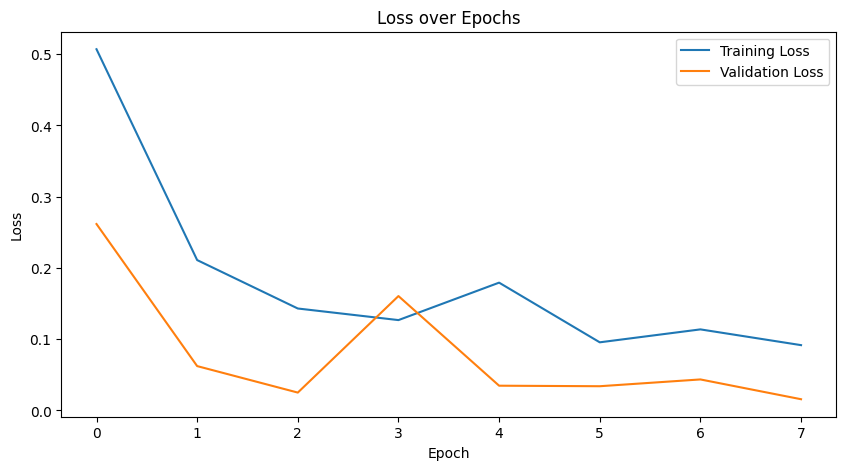

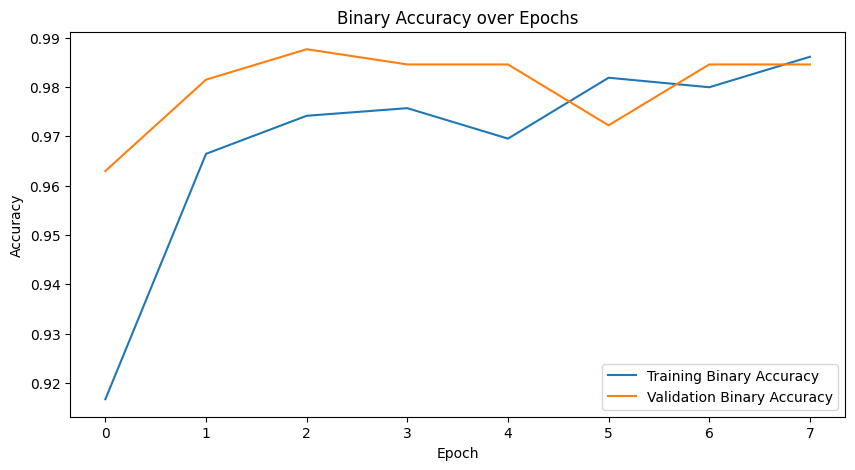

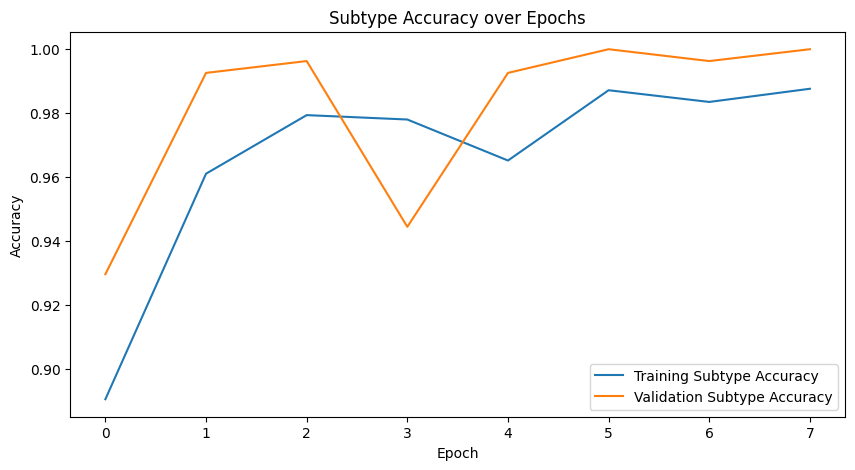

In [13]:
# ============================
# 7. Evaluate the Model
# ============================

# 7.1. Plot Training Curves

def plot_metrics(history):
    # Plot Loss
    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot Binary Accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history['train_acc_binary'], label='Training Binary Accuracy')
    plt.plot(history['val_acc_binary'], label='Validation Binary Accuracy')
    plt.title('Binary Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot Subtype Accuracy
    plt.figure(figsize=(10,5))
    plt.plot(history['train_acc_subtype'], label='Training Subtype Accuracy')
    plt.plot(history['val_acc_subtype'], label='Validation Subtype Accuracy')
    plt.title('Subtype Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Usage
plot_metrics(history)


Binary Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        50
   Malignant       1.00      0.99      1.00       270

    accuracy                           0.99       320
   macro avg       0.98      1.00      0.99       320
weighted avg       0.99      0.99      0.99       320



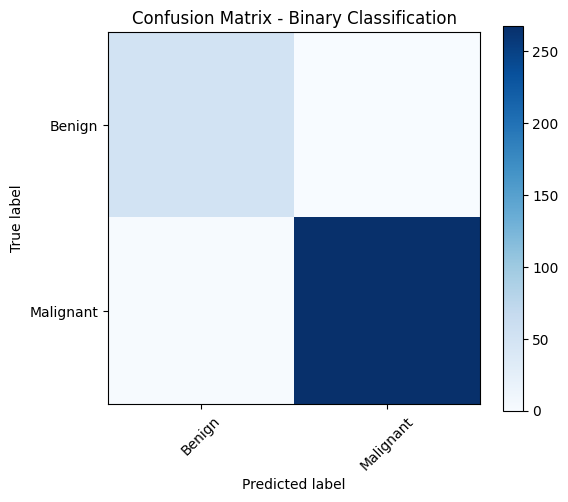


Subtype Classification Report:
              precision    recall  f1-score   support

       Pre-B       1.00      0.99      0.99        93
       Pro-B       0.99      1.00      0.99        80
 early Pre-B       1.00      1.00      1.00        97

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270



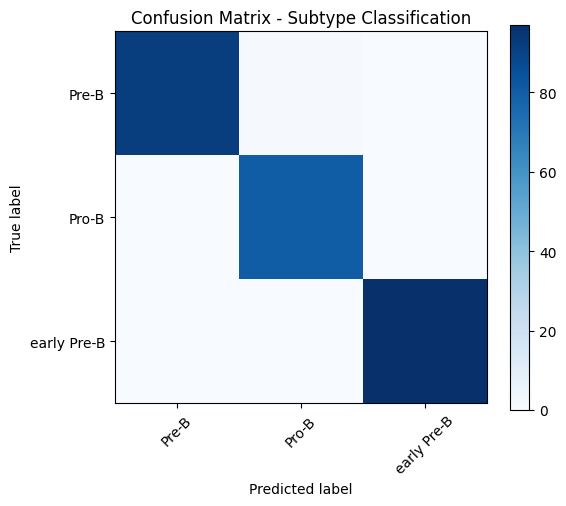

In [14]:
# 7.2. Evaluate on Test Set

def evaluate_model(model, dataloader):
    all_binary_labels = []
    all_binary_preds = []
    all_subtype_labels = []
    all_subtype_preds = []

    model.eval()

    with torch.no_grad():
        for samples in dataloader:
            inputs = samples['image'].to(device)
            binary_labels = samples['binary_label'].to(device)
            subtype_labels = samples['subtype_label'].to(device)

            binary_outputs, subtype_outputs = model(inputs)
            _, binary_preds = torch.max(binary_outputs, 1)

            # Collect binary labels and predictions
            all_binary_labels.extend(binary_labels.cpu().numpy())
            all_binary_preds.extend(binary_preds.cpu().numpy())

            # For subtype classification (only malignant samples)
            subtype_mask = subtype_labels != -1
            if subtype_mask.sum() > 0:
                _, subtype_preds = torch.max(subtype_outputs[subtype_mask], 1)
                all_subtype_labels.extend(subtype_labels[subtype_mask].cpu().numpy())
                all_subtype_preds.extend(subtype_preds.cpu().numpy())

    # Binary Classification Report
    print("Binary Classification Report:")
    print(classification_report(all_binary_labels, all_binary_preds, target_names=['Benign', 'Malignant']))

    # Confusion Matrix for Binary Classification
    cm_binary = confusion_matrix(all_binary_labels, all_binary_preds)
    plt.figure(figsize=(6,5))
    plt.title('Confusion Matrix - Binary Classification')
    plt.imshow(cm_binary, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # Subtype Classification Report
    if all_subtype_labels:
        subtype_target_names = ['Pre-B', 'Pro-B', 'early Pre-B']
        print("\nSubtype Classification Report:")
        print(classification_report(all_subtype_labels, all_subtype_preds, target_names=subtype_target_names))

        # Confusion Matrix for Subtype Classification
        cm_subtype = confusion_matrix(all_subtype_labels, all_subtype_preds)
        plt.figure(figsize=(6,5))
        plt.title('Confusion Matrix - Subtype Classification')
        plt.imshow(cm_subtype, interpolation='nearest', cmap=plt.cm.Blues)
        plt.colorbar()
        tick_marks = np.arange(3)
        plt.xticks(tick_marks, subtype_target_names, rotation=45)
        plt.yticks(tick_marks, subtype_target_names)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
    else:
        print("No malignant samples in the test set for subtype classification.")

# Usage
evaluate_model(model, test_loader)


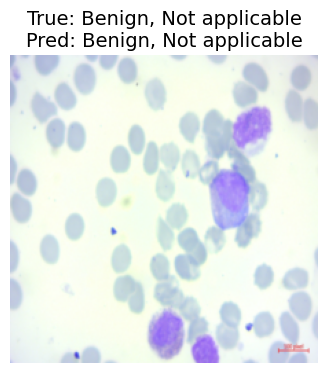

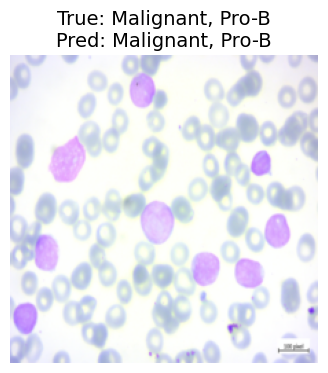

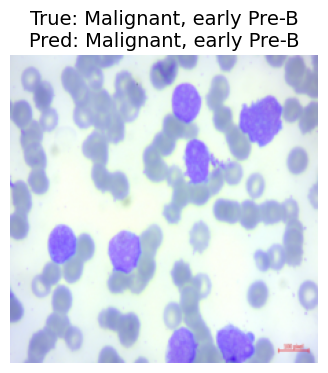

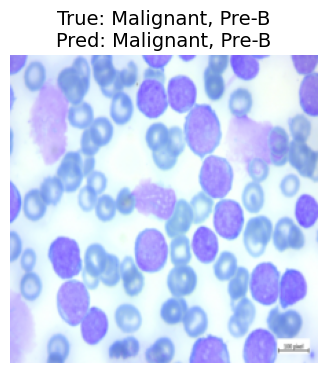

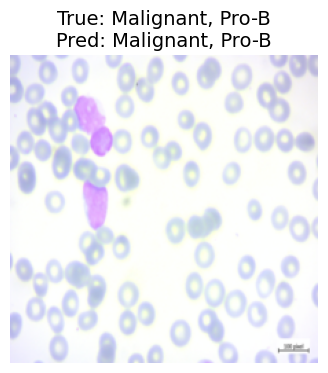

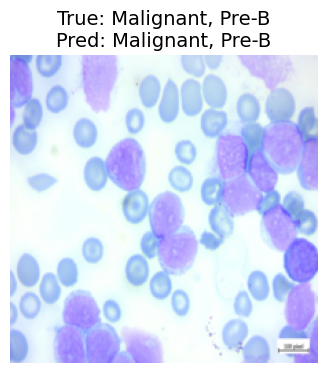

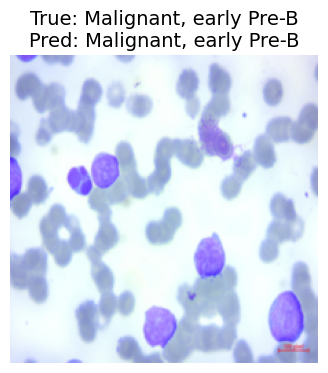

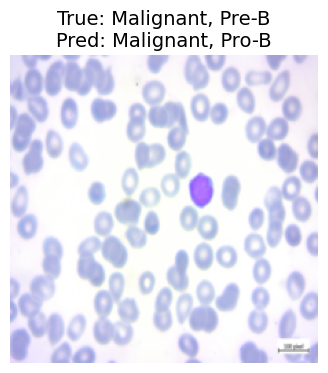

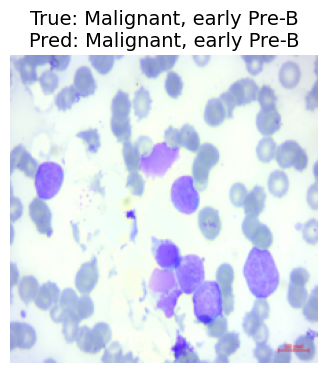

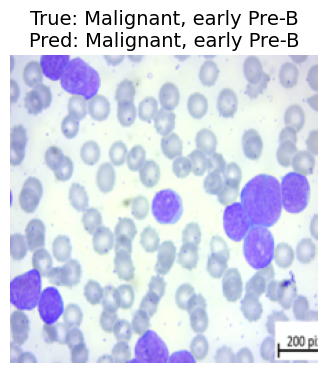

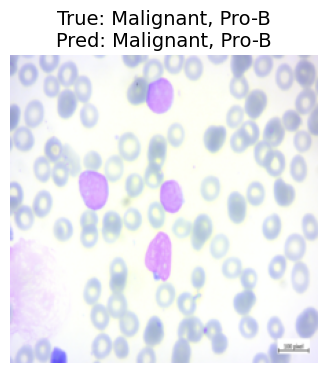

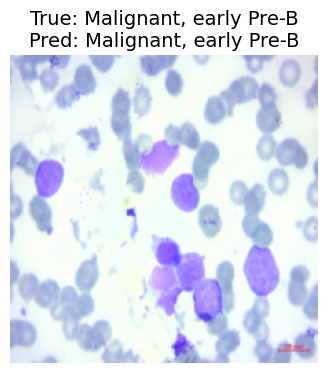

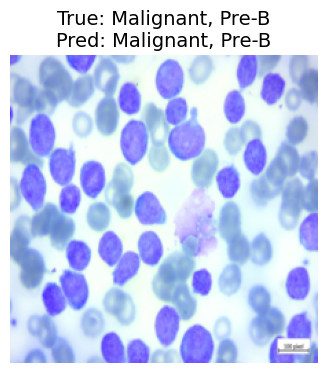

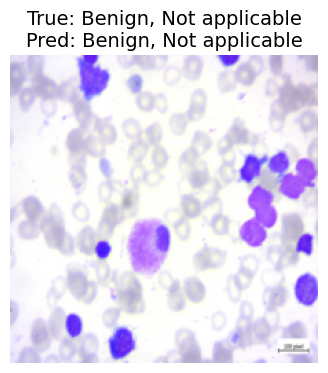

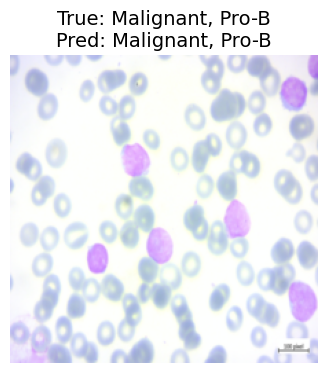

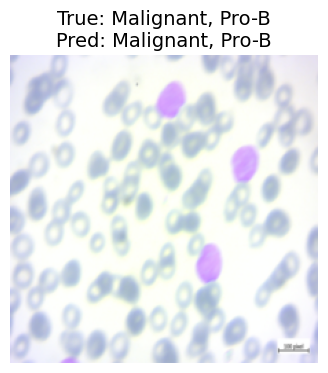

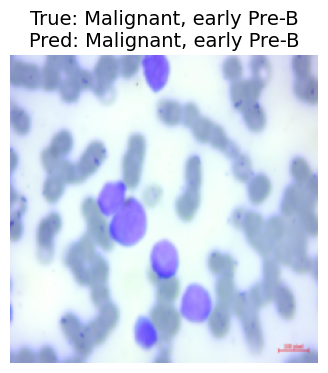

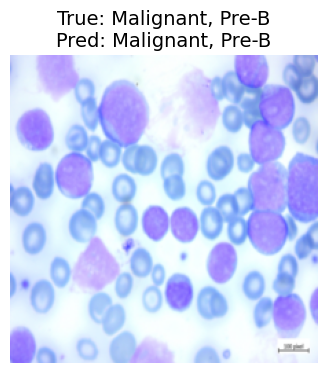

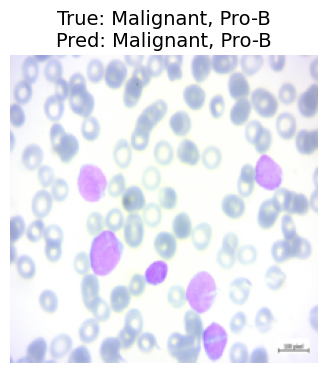

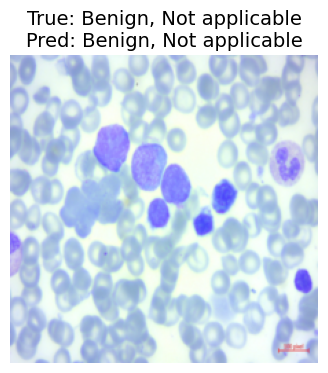

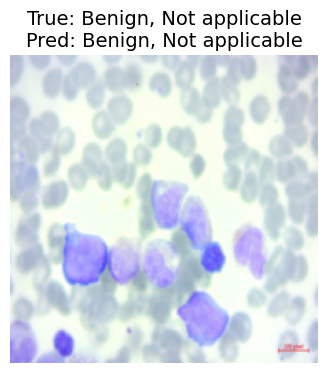

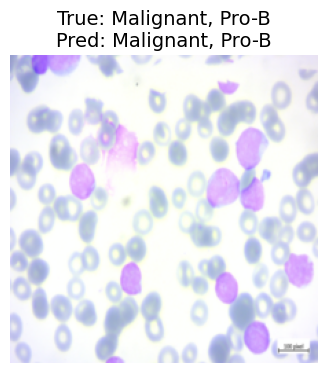

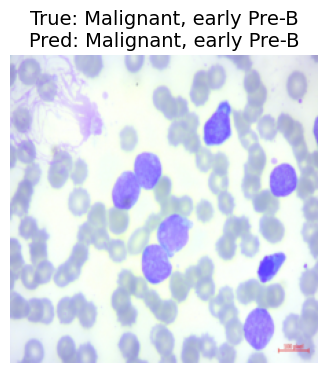

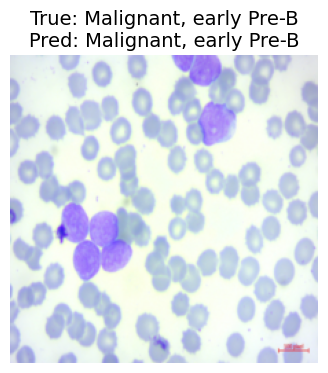

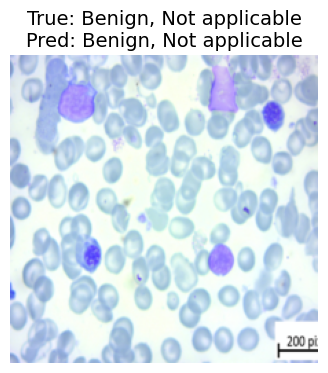

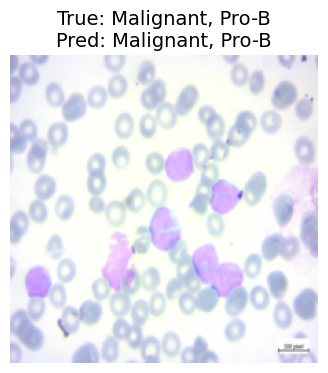

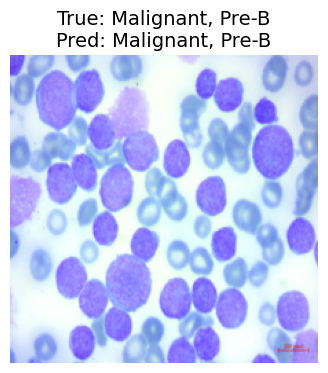

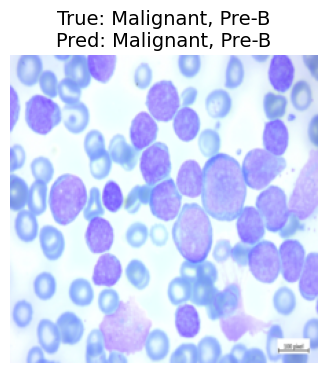

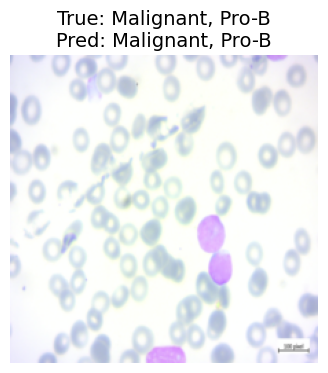

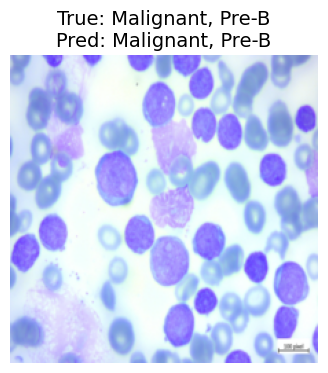

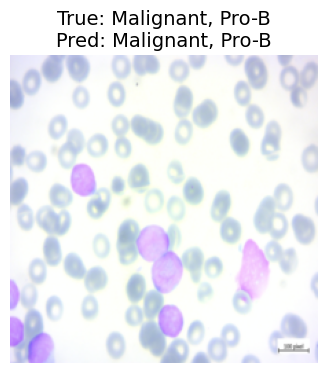

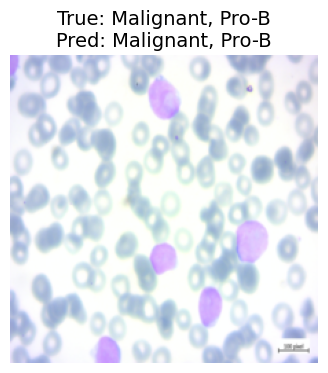

In [15]:
# 7.3. Display Predictions and Actual Labels on Test Set

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])  # Normalization mean
    std = np.array([0.229, 0.224, 0.225])   # Normalization std
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


def show_predictions(model, dataloader, num_batches=1):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, samples in enumerate(dataloader):
            inputs = samples['image'].to(device)
            binary_labels = samples['binary_label'].to(device)
            subtype_labels = samples['subtype_label'].to(device)

            binary_outputs, subtype_outputs = model(inputs)
            _, binary_preds = torch.max(binary_outputs, 1)

            subtype_preds = torch.full_like(subtype_labels, -1)
            # For subtype classification (only malignant samples)
            subtype_mask = binary_preds == 1
            if subtype_mask.sum() > 0:
                _, subtype_out_preds = torch.max(subtype_outputs[subtype_mask], 1)
                subtype_preds[subtype_mask] = subtype_out_preds

            # Move data to CPU
            inputs = inputs.cpu()
            binary_labels = binary_labels.cpu()
            subtype_labels = subtype_labels.cpu()
            binary_preds = binary_preds.cpu()
            subtype_preds = subtype_preds.cpu()

            # Visualize predictions
            for j in range(inputs.size()[0]):
                images_so_far += 1
                img = inputs[j]
                binary_label = binary_label_map[binary_labels[j].item()]
                binary_pred = binary_label_map[binary_preds[j].item()]

                subtype_label = subtype_label_map[subtype_labels[j].item()]
                subtype_pred = subtype_label_map[subtype_preds[j].item()]

                title = f'True: {binary_label}, {subtype_label}\nPred: {binary_pred}, {subtype_pred}'

                plt.figure(figsize=(4,4))
                imshow(img, title=title)
                plt.show()

                if images_so_far >= num_batches * batch_size:
                    return

# Usage
show_predictions(model, test_loader, num_batches=2)


Prediction for Snap_068 (2).jpg:
Binary Classification: Benign
Subtype Classification: Not applicable


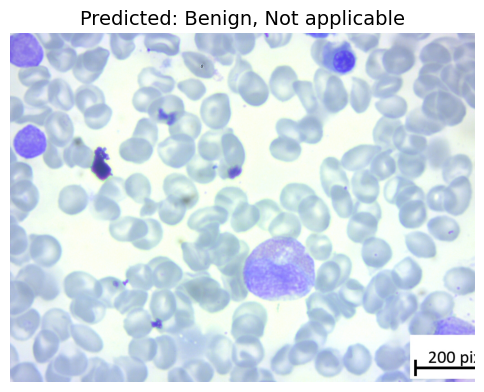

In [ ]:
# ============================
# 8. Inference
# ============================

# 8.1. Predict on Individual Images

def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = val_transforms(image).unsqueeze(0).to(device)
    with torch.no_grad():
        binary_output, subtype_output = model(image_tensor)
        _, binary_pred = torch.max(binary_output, 1)
        binary_class = binary_pred.item()
        binary_class_name = binary_label_map[binary_class]

        if binary_class == 1:  # Malignant
            _, subtype_pred = torch.max(subtype_output, 1)
            subtype_class = subtype_pred.item()
            subtype_class_name = subtype_label_map[subtype_class]
        else:
            subtype_class_name = 'Not applicable'

    print(f"Prediction for {os.path.basename(image_path)}:")
    print(f"Binary Classification: {binary_class_name}")
    print(f"Subtype Classification: {subtype_class_name}")

    # Visualize the image
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(f'Predicted: {binary_class_name}, {subtype_class_name}', fontsize=14)
    plt.axis('off')
    plt.show()

# Usage
# Provide the path to an image in your dataset
sample_image_path = test_dataset.dataframe.iloc[0]['filepath']
predict_image(model, sample_image_path)


In [ ]:
# ============================
# 9. Conclusion
# ============================

print("All tasks completed successfully!")


All tasks completed successfully!
